# Question 1: Extraction des taux zéro-coupon

Date actuelle: 18 septembre 2025

Les coupons obligataires sont semi-annuels.

In [263]:
import numpy as np
import pandas as pd

In [264]:
# Rendements observés sur le marché (en %)
rendements = {
    '4 sem': 4.04,
    '3 mois': 3.89,
    '6 mois': 3.72,
    '1 an': 3.47,
    '2 ans': 3.57,
    '3 ans': 3.55,
    '5 ans': 3.67,
    '7 ans': 3.86,
    '10 ans': 4.11,
    '20 ans': 4.68
}

# Conversion en années pour chaque maturité
maturites = {
    '4 sem': 4/52,
    '3 mois': 0.25,
    '6 mois': 0.5,
    '1 an': 1.0,
    '2 ans': 2.0,
    '3 ans': 3.0,
    '5 ans': 5.0,
    '7 ans': 7.0,
    '10 ans': 10.0,
    '20 ans': 20.0
}

print("Données du marché:")
for periode, taux in rendements.items():
    print(f"{periode}: {taux}%")

Données du marché:
4 sem: 4.04%
3 mois: 3.89%
6 mois: 3.72%
1 an: 3.47%
2 ans: 3.57%
3 ans: 3.55%
5 ans: 3.67%
7 ans: 3.86%
10 ans: 4.11%
20 ans: 4.68%


In [265]:
# Méthode de bootstrapping pour extraire les taux zéro-coupon
# Les bons du Trésor (≤ 1 an) sont déjà des zéro-coupons
# Les obligations (≥ 2 ans) ont des coupons semi-annuels

taux_zero = {}

# Pour les bons du Trésor (≤ 1 an), le rendement = taux zéro-coupon
taux_zero['4 sem'] = rendements['4 sem']
taux_zero['3 mois'] = rendements['3 mois']
taux_zero['6 mois'] = rendements['6 mois']
taux_zero['1 an'] = rendements['1 an']  

print("\nTaux zéro-coupon extraits:")
print(f"4 semaines: {taux_zero['4 sem']:.4f}%")
print(f"3 mois: {taux_zero['3 mois']:.4f}%")
print(f"6 mois: {taux_zero['6 mois']:.4f}%")
print(f"1 an: {taux_zero['1 an']:.4f}%")


Taux zéro-coupon extraits:
4 semaines: 4.0400%
3 mois: 3.8900%
6 mois: 3.7200%
1 an: 3.4700%


In [266]:
# Bootstrapping pour les maturités plus longues (2, 3, 5, 7, 10, 20 ans)
periodes_longues = ['2 ans', '3 ans', '5 ans', '7 ans', '10 ans', '20 ans']

# Stocker tous les taux zéro en format annualisé (composé semestriellement)
z_dict = {
    4/52: taux_zero['4 sem'] / 100,
    0.25: taux_zero['3 mois'] / 100,
    0.5: taux_zero['6 mois'] / 100,
    1.0: taux_zero['1 an'] / 100
}

for periode in periodes_longues:
    T = maturites[periode] 
    y = rendements[periode] / 100
    coupon = (y / 2) * 100
    
    # Calculer la valeur actuelle de tous les coupons sauf le dernier
    n_coupons = int(T * 2) 
    va_coupons = 0
    
    for i in range(1, n_coupons):
        t = i * 0.5
        # Trouver le taux zéro approprié (interpolation si nécessaire)
        if t in z_dict:
            z_t = z_dict[t]
        else:
            # Interpolation linéaire simple
            temps_disponibles = sorted([k for k in z_dict.keys() if k <= t])
            if temps_disponibles:
                t_avant = max(temps_disponibles)
                temps_apres = [k for k in z_dict.keys() if k > t]
                if temps_apres:
                    t_apres = min(temps_apres)
                    # Interpolation linéaire
                    poids = (t - t_avant) / (t_apres - t_avant)
                    z_t = z_dict[t_avant] * (1 - poids) + z_dict[t_apres] * poids
                else:
                    z_t = z_dict[t_avant]
            else:
                z_t = 0.04  # Valeur par défaut
        
        va_coupons += coupon / (1 + z_t/2)**(i)
    
    # Résoudre pour le taux zéro à maturité T
    # 100 = va_coupons + (coupon + 100) / (1 + z_T/2)^(2T)
    valeur_finale = coupon + 100
    va_restante = 100 - va_coupons
    
    z_T_semi = (valeur_finale / va_restante)**(1/(n_coupons)) - 1
    z_T = z_T_semi * 2
    
    taux_zero[periode] = z_T * 100
    z_dict[T] = z_T

print("\nTous les taux zéro-coupon extraits:")
for periode in rendements.keys():
    print(f"{periode}: {taux_zero[periode]:.4f}%")


Tous les taux zéro-coupon extraits:
4 sem: 4.0400%
3 mois: 3.8900%
6 mois: 3.7200%
1 an: 3.4700%
2 ans: 3.5716%
3 ans: 3.5497%
5 ans: 3.6803%
7 ans: 3.8912%
10 ans: 4.1847%
20 ans: 5.0901%


In [267]:
# Tableau récapitulatif
df = pd.DataFrame({
    'Maturité': list(rendements.keys()),
    'Rendement du marché (%)': list(rendements.values()),
    'Taux zéro-coupon (%)': [taux_zero[p] for p in rendements.keys()]
})

print("\nTableau récapitulatif:")
print(df.to_string(index=False))


Tableau récapitulatif:
Maturité  Rendement du marché (%)  Taux zéro-coupon (%)
   4 sem                     4.04              4.040000
  3 mois                     3.89              3.890000
  6 mois                     3.72              3.720000
    1 an                     3.47              3.470000
   2 ans                     3.57              3.571556
   3 ans                     3.55              3.549651
   5 ans                     3.67              3.680329
   7 ans                     3.86              3.891213
  10 ans                     4.11              4.184747
  20 ans                     4.68              5.090134


# Question 2: Lissage de Nelson-Siegel-Svensson

Appliquer la fonction de lissage de **Nelson-Siegel-Svensson (NSS)** aux taux zéro-coupon extraits.

Le modèle NSS est défini par :

$$y(m) = \beta_0 + \beta_1 \left(\frac{1 - e^{-m/\tau_1}}{m/\tau_1}\right) + \beta_2 \left(\frac{1 - e^{-m/\tau_1}}{m/\tau_1} - e^{-m/\tau_1}\right) + \beta_3 \left(\frac{1 - e^{-m/\tau_2}}{m/\tau_2} - e^{-m/\tau_2}\right)$$

où :
- $m$ = maturité en années
- $\beta_0, \beta_1, \beta_2, \beta_3$ = paramètres de forme
- $\tau_1, \tau_2$ = paramètres de décroissance exponentielle

In [268]:
# Préparation des données pour le lissage NSS
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# Extraire les maturités et taux zéro-coupon
maturites_nss = np.array([maturites[p] for p in rendements.keys()])
taux_zero_nss = np.array([taux_zero[p] for p in rendements.keys()])

print("Données pour le lissage NSS:")
print("="*60)
for i, (mat, taux) in enumerate(zip(maturites_nss, taux_zero_nss)):
    print(f"Maturité {mat:6.4f} an(s): Taux zéro = {taux:.4f}%")
print("="*60)

Données pour le lissage NSS:
Maturité 0.0769 an(s): Taux zéro = 4.0400%
Maturité 0.2500 an(s): Taux zéro = 3.8900%
Maturité 0.5000 an(s): Taux zéro = 3.7200%
Maturité 1.0000 an(s): Taux zéro = 3.4700%
Maturité 2.0000 an(s): Taux zéro = 3.5716%
Maturité 3.0000 an(s): Taux zéro = 3.5497%
Maturité 5.0000 an(s): Taux zéro = 3.6803%
Maturité 7.0000 an(s): Taux zéro = 3.8912%
Maturité 10.0000 an(s): Taux zéro = 4.1847%
Maturité 20.0000 an(s): Taux zéro = 5.0901%


In [269]:
# Fonction de Nelson-Siegel-Svensson
def nelson_siegel_svensson(m, beta0, beta1, beta2, beta3, tau1, tau2):
    """
    Calcule le taux selon le modèle Nelson-Siegel-Svensson
    
    Paramètres:
        m: maturité (années)
        beta0, beta1, beta2, beta3: paramètres de forme
        tau1, tau2: paramètres de décroissance
    
    Retourne:
        Taux (en %)
    """
    # Cas limite pour maturité nulle
    if m == 0:
        return beta0 + beta1
    
    # Calcul des termes
    term1 = (1 - np.exp(-m/tau1)) / (m/tau1)
    term2 = term1 - np.exp(-m/tau1)
    term3 = (1 - np.exp(-m/tau2)) / (m/tau2) - np.exp(-m/tau2)
    
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# Fonction objectif à minimiser
def nss_objective(params, maturites, taux_observes):
    """
    Calcule la somme des carrés des erreurs (SSE)
    entre taux observés et taux prédits par NSS
    """
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    
    # Calculer les taux prédits
    taux_predits = np.array([
        nelson_siegel_svensson(m, beta0, beta1, beta2, beta3, tau1, tau2) 
        for m in maturites
    ])
    
    # Somme des carrés des erreurs
    sse = np.sum((taux_observes - taux_predits)**2)
    
    return sse

print("Fonction Nelson-Siegel-Svensson définie.")
print("Fonction objectif: minimisation de la somme des carrés des erreurs (SSE)")

Fonction Nelson-Siegel-Svensson définie.
Fonction objectif: minimisation de la somme des carrés des erreurs (SSE)


In [270]:
# Optimisation des paramètres NSS
print("="*70)
print("OPTIMISATION DES PARAMÈTRES NELSON-SIEGEL-SVENSSON")
print("="*70)
print("\nOptimisation en cours...")

# Définir les bornes pour les paramètres
# beta0, beta1, beta2, beta3: peuvent être négatifs ou positifs
# tau1, tau2: doivent être strictement positifs
bounds_nss = [
    (-10, 10),    # beta0
    (-10, 10),    # beta1
    (-10, 10),    # beta2
    (-10, 10),    # beta3
    (0.1, 10),    # tau1
    (0.1, 15)     # tau2
]

# Utiliser differential_evolution pour une optimisation globale robuste
result_nss = differential_evolution(
    nss_objective, 
    bounds_nss, 
    args=(maturites_nss, taux_zero_nss),
    seed=42,
    maxiter=1000,
    tol=1e-10,
    disp=False
)

# Extraire les paramètres optimaux
beta0_nss, beta1_nss, beta2_nss, beta3_nss, tau1_nss, tau2_nss = result_nss.x
sse_nss = result_nss.fun

# Afficher les résultats
print("\n" + "="*70)
print("RÉSULTATS DE L'OPTIMISATION NSS")
print("="*70)
print(f"\nParamètres optimaux:")
print(f"  β₀ = {beta0_nss:10.6f}")
print(f"  β₁ = {beta1_nss:10.6f}")
print(f"  β₂ = {beta2_nss:10.6f}")
print(f"  β₃ = {beta3_nss:10.6f}")
print(f"  τ₁ = {tau1_nss:10.6f}")
print(f"  τ₂ = {tau2_nss:10.6f}")

print(f"\nValeur minimisée de la fonction objectif (SSE): {sse_nss:.8f}")
print(f"RMSE (Root Mean Square Error): {np.sqrt(sse_nss/len(maturites_nss)):.6f}%")
print(f"R² (coefficient de détermination): {1 - sse_nss/np.sum((taux_zero_nss - np.mean(taux_zero_nss))**2):.6f}")
print("="*70)

OPTIMISATION DES PARAMÈTRES NELSON-SIEGEL-SVENSSON

Optimisation en cours...

RÉSULTATS DE L'OPTIMISATION NSS

Paramètres optimaux:
  β₀ =   6.515812
  β₁ =  -2.348287
  β₂ =  -3.112828
  β₃ =  -7.021415
  τ₁ =   0.712861
  τ₂ =   3.599187

Valeur minimisée de la fonction objectif (SSE): 0.01003950
RMSE (Root Mean Square Error): 0.031685%
R² (coefficient de détermination): 0.995012

RÉSULTATS DE L'OPTIMISATION NSS

Paramètres optimaux:
  β₀ =   6.515812
  β₁ =  -2.348287
  β₂ =  -3.112828
  β₃ =  -7.021415
  τ₁ =   0.712861
  τ₂ =   3.599187

Valeur minimisée de la fonction objectif (SSE): 0.01003950
RMSE (Root Mean Square Error): 0.031685%
R² (coefficient de détermination): 0.995012


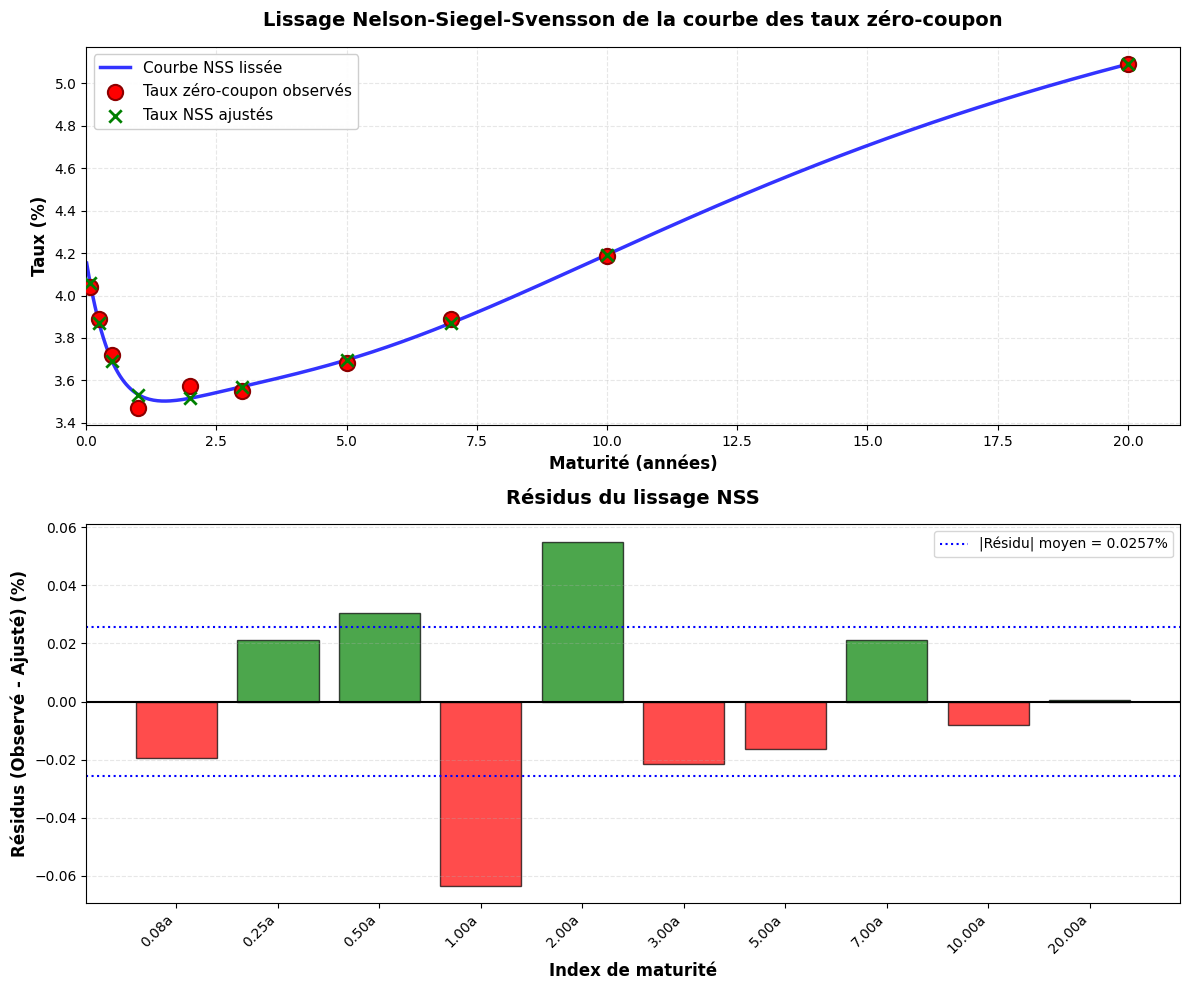


Résidus pour chaque maturité:
Maturité        Observé (%)  NSS (%)      Résidu (%)  
4 sem                4.0400      4.0595     -0.0195
3 mois               3.8900      3.8687     +0.0213
6 mois               3.7200      3.6896     +0.0304
1 an                 3.4700      3.5333     -0.0633
2 ans                3.5716      3.5165     +0.0551
3 ans                3.5497      3.5711     -0.0215
5 ans                3.6803      3.6966     -0.0163
7 ans                3.8912      3.8700     +0.0212
10 ans               4.1847      4.1927     -0.0080
20 ans               5.0901      5.0896     +0.0006


In [271]:
# Visualisation de la qualité du lissage NSS
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Générer une courbe lisse pour la visualisation
maturites_curve = np.linspace(0.01, 20, 500)
taux_nss_curve = np.array([
    nelson_siegel_svensson(m, beta0_nss, beta1_nss, beta2_nss, beta3_nss, tau1_nss, tau2_nss) 
    for m in maturites_curve
])

# Calculer les taux NSS pour les points observés
taux_nss_points = np.array([
    nelson_siegel_svensson(m, beta0_nss, beta1_nss, beta2_nss, beta3_nss, tau1_nss, tau2_nss) 
    for m in maturites_nss
])

# GRAPHIQUE 1: Courbe lissée vs points observés
ax1.plot(maturites_curve, taux_nss_curve, 'b-', linewidth=2.5, label='Courbe NSS lissée', alpha=0.8)
ax1.scatter(maturites_nss, taux_zero_nss, color='red', s=120, zorder=5, 
            label='Taux zéro-coupon observés', edgecolors='darkred', linewidth=1.5)
ax1.scatter(maturites_nss, taux_nss_points, color='green', s=80, marker='x', 
            linewidth=2, zorder=5, label='Taux NSS ajustés')

ax1.set_xlabel('Maturité (années)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Taux (%)', fontsize=12, fontweight='bold')
ax1.set_title('Lissage Nelson-Siegel-Svensson de la courbe des taux zéro-coupon', 
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='best', framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(0, 21)

# GRAPHIQUE 2: Résidus (erreurs d'ajustement)
residus_nss = taux_zero_nss - taux_nss_points
colors_residus = ['red' if r < 0 else 'green' for r in residus_nss]

ax2.bar(range(len(maturites_nss)), residus_nss, color=colors_residus, alpha=0.7, 
        edgecolor='black', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax2.set_xlabel('Index de maturité', fontsize=12, fontweight='bold')
ax2.set_ylabel('Résidus (Observé - Ajusté) (%)', fontsize=12, fontweight='bold')
ax2.set_title('Résidus du lissage NSS', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(range(len(maturites_nss)))
ax2.set_xticklabels([f"{m:.2f}a" for m in maturites_nss], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

# Ajouter une ligne de référence pour les résidus moyens
mean_residu = np.mean(np.abs(residus_nss))
ax2.axhline(y=mean_residu, color='blue', linestyle=':', linewidth=1.5, 
            label=f'|Résidu| moyen = {mean_residu:.4f}%')
ax2.axhline(y=-mean_residu, color='blue', linestyle=':', linewidth=1.5)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\nRésidus pour chaque maturité:")
print("="*70)
print(f"{'Maturité':<15} {'Observé (%)':<12} {'NSS (%)':<12} {'Résidu (%)':<12}")
print("="*70)
for i, (p, m, obs, pred, res) in enumerate(zip(rendements.keys(), maturites_nss, 
                                                  taux_zero_nss, taux_nss_points, residus_nss)):
    print(f"{p:<15} {obs:>11.4f} {pred:>11.4f} {res:>+11.4f}")
print("="*70)

In [272]:
# Tableau récapitulatif comparatif NSS
df_nss_comparison = pd.DataFrame({
    'Maturité': list(rendements.keys()),
    'Maturité (années)': maturites_nss,
    'Taux zéro observé (%)': taux_zero_nss,
    'Taux NSS ajusté (%)': taux_nss_points,
    'Résidu (%)': residus_nss,
    'Résidu² (%)': residus_nss**2
})

print("\n" + "="*90)
print("TABLEAU COMPARATIF - TAUX OBSERVÉS VS TAUX NSS")
print("="*90)
print(df_nss_comparison.to_string(index=False, float_format=lambda x: f'{x:.6f}'))
print("="*90)

# Statistiques sur la qualité de l'ajustement
print(f"\nStatistiques de l'ajustement NSS:")
print(f"  Résidu moyen:           {np.mean(residus_nss):>10.6f}%")
print(f"  Résidu médian:          {np.median(residus_nss):>10.6f}%")
print(f"  |Résidu| moyen:         {np.mean(np.abs(residus_nss)):>10.6f}%")
print(f"  Écart-type des résidus: {np.std(residus_nss):>10.6f}%")
print(f"  Résidu max (abs):       {np.max(np.abs(residus_nss)):>10.6f}%")
print(f"  SSE (somme carrés):     {sse_nss:>10.6f}")
print(f"  RMSE:                   {np.sqrt(sse_nss/len(maturites_nss)):>10.6f}%")
print(f"  R²:                     {1 - sse_nss/np.sum((taux_zero_nss - np.mean(taux_zero_nss))**2):>10.6f}")

print("\n" + "="*70)
print("CONCLUSION - QUESTION 2")
print("="*70)
print("Le modèle Nelson-Siegel-Svensson a été calibré avec succès.")
print(f"\nParamètres estimés:")
print(f"  β₀={beta0_nss:.4f}, β₁={beta1_nss:.4f}, β₂={beta2_nss:.4f}, β₃={beta3_nss:.4f}")
print(f"  τ₁={tau1_nss:.4f}, τ₂={tau2_nss:.4f}")
print(f"\nFonction objectif minimisée: SSE = {sse_nss:.6f}")
print(f"La courbe lissée capture bien la structure des taux zéro-coupon.")
print("="*70)


TABLEAU COMPARATIF - TAUX OBSERVÉS VS TAUX NSS
Maturité  Maturité (années)  Taux zéro observé (%)  Taux NSS ajusté (%)  Résidu (%)  Résidu² (%)
   4 sem           0.076923               4.040000             4.059473   -0.019473     0.000379
  3 mois           0.250000               3.890000             3.868710    0.021290     0.000453
  6 mois           0.500000               3.720000             3.689618    0.030382     0.000923
    1 an           1.000000               3.470000             3.533338   -0.063338     0.004012
   2 ans           2.000000               3.571556             3.516470    0.055086     0.003035
   3 ans           3.000000               3.549651             3.571127   -0.021476     0.000461
   5 ans           5.000000               3.680329             3.696586   -0.016257     0.000264
   7 ans           7.000000               3.891213             3.870030    0.021184     0.000449
  10 ans          10.000000               4.184747             4.192698   -0.00

# Question 3: Calibrage du modèle gaussien à deux facteurs

**Date:** 19 septembre 2025 (t = 0.003 années écoulées depuis le 18 septembre)

**Objectif:** Calibrer un modèle gaussien à deux facteurs en minimisant l'erreur relative sur les prix de marché des caps.

## Formulation du problème

Le modèle est calibré en résolvant:

$$\min_{\Theta} \sum_{j=1}^{3} \sum_{k=1}^{10} \left(\frac{cap_{bm}(K_j, T_k) - cap_{mkt}(K_j, T_k)}{cap_{mkt}(K_j, T_k)}\right)^2$$

où:
- $\Theta$ = ensemble des paramètres du modèle gaussien à deux facteurs
- $j$ indexe les 3 niveaux de strike: $0.85K_f$, $K_f$, $1.15K_f$
- $k$ indexe les 10 maturités (1 à 10 ans)
- $cap_{bm}$ = prix du cap selon le modèle
- $cap_{mkt}$ = prix du cap de marché
- $K_f$ = taux swap forward (at-the-money)

In [273]:
# Données de marché: Volatilités implicites des caps (en %)
# Date: 19 septembre 2025 (t = 0.003 années)

# Maturités des caps
cap_maturites_q3 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Volatilités implicites pour 0.85*Kf (In-The-Money)
vol_085Kf = np.array([20.90, 24.44, 25.67, 26.02, 26.04, 25.86, 25.37, 25.24, 25.05, 24.82])

# Volatilités implicites pour Kf (At-The-Money)
vol_Kf = np.array([16.62, 22.42, 24.42, 24.95, 24.95, 24.69, 24.09, 23.84, 23.56, 23.21])

# Volatilités implicites pour 1.15*Kf (Out-Of-The-Money)
vol_115Kf = np.array([14.28, 19.58, 22.51, 23.48, 23.72, 23.62, 23.15, 23.01, 22.82, 22.57])

# Créer un DataFrame pour visualiser
df_caps_q3 = pd.DataFrame({
    'Maturité (années)': cap_maturites_q3,
    'Vol 0.85Kf (%)': vol_085Kf,
    'Vol Kf (%)': vol_Kf,
    'Vol 1.15Kf (%)': vol_115Kf
})

print("="*75)
print("VOLATILITÉS IMPLICITES DES CAPS - MARCHÉ")
print("="*75)
print(df_caps_q3.to_string(index=False))
print("="*75)

VOLATILITÉS IMPLICITES DES CAPS - MARCHÉ
 Maturité (années)  Vol 0.85Kf (%)  Vol Kf (%)  Vol 1.15Kf (%)
                 1           20.90       16.62           14.28
                 2           24.44       22.42           19.58
                 3           25.67       24.42           22.51
                 4           26.02       24.95           23.48
                 5           26.04       24.95           23.72
                 6           25.86       24.69           23.62
                 7           25.37       24.09           23.15
                 8           25.24       23.84           23.01
                 9           25.05       23.56           22.82
                10           24.82       23.21           22.57


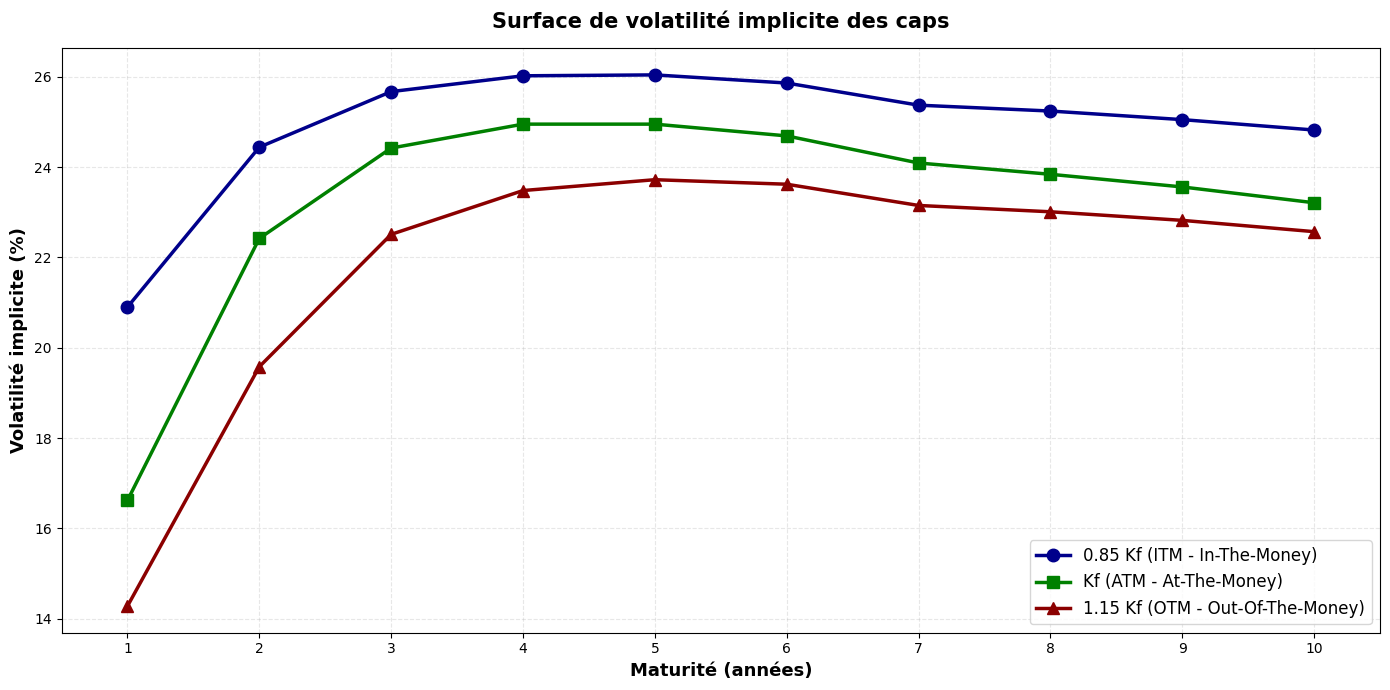


Observations:
  • Les volatilités décroissent avec le niveau de strike (smile de volatilité)
  • Les volatilités augmentent avec la maturité puis se stabilisent
  • Structure typique de volatilité implicite pour les caps de taux


In [274]:
# Visualisation de la surface de volatilité implicite
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(cap_maturites_q3, vol_085Kf, 'o-', linewidth=2.5, markersize=9, 
        label='0.85 Kf (ITM - In-The-Money)', color='darkblue')
ax.plot(cap_maturites_q3, vol_Kf, 's-', linewidth=2.5, markersize=9, 
        label='Kf (ATM - At-The-Money)', color='green')
ax.plot(cap_maturites_q3, vol_115Kf, '^-', linewidth=2.5, markersize=9, 
        label='1.15 Kf (OTM - Out-Of-The-Money)', color='darkred')

ax.set_xlabel('Maturité (années)', fontsize=13, fontweight='bold')
ax.set_ylabel('Volatilité implicite (%)', fontsize=13, fontweight='bold')
ax.set_title('Surface de volatilité implicite des caps', fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(cap_maturites_q3)
ax.set_xlim(0.5, 10.5)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("  • Les volatilités décroissent avec le niveau de strike (smile de volatilité)")
print("  • Les volatilités augmentent avec la maturité puis se stabilisent")
print("  • Structure typique de volatilité implicite pour les caps de taux")

In [275]:
# Calcul des taux forward et des prix de marché des caps
from scipy.stats import norm

# Fonction pour calculer le taux forward à partir de la courbe NSS
def get_forward_rate_nss(T1, T2):
    """Calcule le taux forward entre T1 et T2 en utilisant la courbe NSS"""
    if T1 >= T2:
        return 0.0
    r1 = nelson_siegel_svensson(T1, beta0_nss, beta1_nss, beta2_nss, beta3_nss, tau1_nss, tau2_nss) / 100
    r2 = nelson_siegel_svensson(T2, beta0_nss, beta1_nss, beta2_nss, beta3_nss, tau1_nss, tau2_nss) / 100
    # Taux forward
    forward = ((1 + r2)**T2 / (1 + r1)**T1)**(1/(T2-T1)) - 1
    return forward

# Fonction pour calculer le facteur d'actualisation
def get_discount_factor_nss(T):
    """Calcule le facteur d'actualisation pour la maturité T"""
    r = nelson_siegel_svensson(T, beta0_nss, beta1_nss, beta2_nss, beta3_nss, tau1_nss, tau2_nss) / 100
    return 1 / (1 + r)**T

# Fonction de Black pour pricer un caplet
def black_caplet(forward_rate, strike, volatility, maturity, discount_factor, notional=100):
    """Prix d'un caplet selon la formule de Black"""
    if maturity <= 0 or volatility <= 0:
        return 0.0
    
    d1 = (np.log(forward_rate / strike) + 0.5 * volatility**2 * maturity) / (volatility * np.sqrt(maturity))
    d2 = d1 - volatility * np.sqrt(maturity)
    
    price = notional * discount_factor * (forward_rate * norm.cdf(d1) - strike * norm.cdf(d2))
    return price

# Estimer les taux forward ATM (Kf) pour chaque maturité
forward_rates_kf = []
for T in cap_maturites_q3:
    if T == 1:
        fwd = get_forward_rate_nss(0, 1)
    else:
        fwd = get_forward_rate_nss(T-1, T)
    forward_rates_kf.append(fwd * 100)  # En pourcentage

print("\nTaux forward estimés (Kf) pour chaque maturité:")
print("="*60)
for T, fwd in zip(cap_maturites_q3, forward_rates_kf):
    print(f"  Maturité {T:2d} an(s): Kf = {fwd:6.4f}%")
print("="*60)


Taux forward estimés (Kf) pour chaque maturité:
  Maturité  1 an(s): Kf = 3.5333%
  Maturité  2 an(s): Kf = 3.4996%
  Maturité  3 an(s): Kf = 3.6805%
  Maturité  4 an(s): Kf = 3.8058%
  Maturité  5 an(s): Kf = 3.9644%
  Maturité  6 an(s): Kf = 4.1789%
  Maturité  7 an(s): Kf = 4.4311%
  Maturité  8 an(s): Kf = 4.6965%
  Maturité  9 an(s): Kf = 4.9558%
  Maturité 10 an(s): Kf = 5.1968%


In [276]:
# Calculer les prix de marché des caps à partir des volatilités implicites
def calculate_cap_price_market(maturity, strike_multiplier, volatility, forward_rate_kf):
    """
    Calcule le prix d'un cap (simplifié comme un caplet unique)
    """
    strike = (strike_multiplier * forward_rate_kf) / 100
    fwd = forward_rate_kf / 100
    vol = volatility / 100
    discount = get_discount_factor_nss(maturity)
    
    price = black_caplet(fwd, strike, vol, maturity, discount, notional=100)
    return price

# Calculer les prix de marché pour tous les caps (3 strikes × 10 maturités)
market_cap_prices = np.zeros((3, len(cap_maturites_q3)))

for i, T in enumerate(cap_maturites_q3):
    fwd_kf = forward_rates_kf[i]
    
    # Prix pour les 3 niveaux de strike
    market_cap_prices[0, i] = calculate_cap_price_market(T, 0.85, vol_085Kf[i], fwd_kf)
    market_cap_prices[1, i] = calculate_cap_price_market(T, 1.00, vol_Kf[i], fwd_kf)
    market_cap_prices[2, i] = calculate_cap_price_market(T, 1.15, vol_115Kf[i], fwd_kf)

print("\n" + "="*75)
print("PRIX DE MARCHÉ DES CAPS (calculés à partir des volatilités implicites)")
print("="*75)

df_cap_prices_q3 = pd.DataFrame(
    market_cap_prices.T,
    columns=['Prix 0.85Kf', 'Prix Kf', 'Prix 1.15Kf'],
    index=[f'{T} an' for T in cap_maturites_q3]
)

print(df_cap_prices_q3.to_string(float_format=lambda x: f'{x:.6f}'))
print("="*75)


PRIX DE MARCHÉ DES CAPS (calculés à partir des volatilités implicites)
       Prix 0.85Kf  Prix Kf  Prix 1.15Kf
1 an      0.593868 0.226020     0.045262
2 an      0.703854 0.411381     0.189478
3 an      0.822495 0.554859     0.336455
4 an      0.903688 0.650175     0.439403
5 an      0.974800 0.726469     0.520405
6 an      1.044318 0.795031     0.590823
7 an      1.103769 0.849328     0.645782
8 an      1.166839 0.907831     0.706101
9 an      1.216745 0.954952     0.756130
10 an     1.251332 0.986938     0.793341


In [277]:
# Modèle gaussien à deux facteurs avec 7 paramètres
class TwoFactorGaussianModelQ3:
    """
    Modèle gaussien à deux facteurs pour les taux d'intérêt
    
    Paramètres (7 au total):
        x0, y0: valeurs initiales des deux facteurs (proches de 0)
        sigma1, sigma2: volatilités des deux facteurs
        kappa1, kappa2: vitesses de retour à la moyenne (> 0)
        rho: corrélation entre les deux facteurs (-1 ≤ rho ≤ 1)
    """
    
    def __init__(self, x0, y0, sigma1, sigma2, kappa1, kappa2, rho):
        self.x0 = x0
        self.y0 = y0
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.kappa1 = kappa1
        self.kappa2 = kappa2
        self.rho = rho
    
    def caplet_volatility(self, T):
        """
        Calcule la volatilité Black équivalente pour un caplet de maturité T
        """
        if T <= 0:
            return 0.0
        
        # Variance du premier facteur
        if self.kappa1 > 0:
            var1 = (self.sigma1**2 / (2 * self.kappa1)) * (1 - np.exp(-2 * self.kappa1 * T))
        else:
            var1 = self.sigma1**2 * T
        
        # Variance du second facteur
        if self.kappa2 > 0:
            var2 = (self.sigma2**2 / (2 * self.kappa2)) * (1 - np.exp(-2 * self.kappa2 * T))
        else:
            var2 = self.sigma2**2 * T
        
        # Terme de corrélation
        if self.kappa1 > 0 and self.kappa2 > 0:
            var_cross = 2 * self.rho * self.sigma1 * self.sigma2 / (self.kappa1 + self.kappa2) * \
                       (1 - np.exp(-(self.kappa1 + self.kappa2) * T))
        else:
            var_cross = 2 * self.rho * self.sigma1 * self.sigma2 * T
        
        # Variance totale
        total_var = var1 + var2 + var_cross
        
        # Volatilité Black équivalente
        if total_var > 0 and T > 0:
            vol = np.sqrt(total_var / T)
        else:
            vol = 0.0
        
        return vol * 100  # En pourcentage
    
    def cap_price(self, maturity, strike_multiplier, forward_rate_kf):
        """
        Calcule le prix d'un cap dans le modèle
        """
        model_vol = self.caplet_volatility(maturity)
        
        strike = (strike_multiplier * forward_rate_kf) / 100
        fwd = forward_rate_kf / 100
        vol = model_vol / 100
        discount = get_discount_factor_nss(maturity)
        
        if maturity <= 0 or vol <= 0:
            return 0.0
        
        d1 = (np.log(fwd / strike) + 0.5 * vol**2 * maturity) / (vol * np.sqrt(maturity))
        d2 = d1 - vol * np.sqrt(maturity)
        
        price = 100 * discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
        return price

print("Modèle gaussien à deux facteurs (7 paramètres) défini.")
print("\nParamètres du modèle:")
print("  1. x₀ : valeur initiale du facteur 1")
print("  2. y₀ : valeur initiale du facteur 2")
print("  3. σ₁ : volatilité du facteur 1")
print("  4. σ₂ : volatilité du facteur 2")
print("  5. κ₁ : vitesse de retour à la moyenne du facteur 1")
print("  6. κ₂ : vitesse de retour à la moyenne du facteur 2")
print("  7. ρ  : corrélation entre les deux facteurs")

Modèle gaussien à deux facteurs (7 paramètres) défini.

Paramètres du modèle:
  1. x₀ : valeur initiale du facteur 1
  2. y₀ : valeur initiale du facteur 2
  3. σ₁ : volatilité du facteur 1
  4. σ₂ : volatilité du facteur 2
  5. κ₁ : vitesse de retour à la moyenne du facteur 1
  6. κ₂ : vitesse de retour à la moyenne du facteur 2
  7. ρ  : corrélation entre les deux facteurs


In [278]:
# Fonction objectif pour le calibrage
def calibration_objective_q3(params):
    """
    Fonction objectif: somme des erreurs relatives au carré
    params = [x0, y0, sigma1, sigma2, kappa1, kappa2, rho]
    """
    x0, y0, sigma1, sigma2, kappa1, kappa2, rho = params
    
    # CONTRAINTES:
    # 1. kappa strictement positifs
    if kappa1 <= 0 or kappa2 <= 0:
        return 1e10

    # 2. Corrélation entre -1 et 1
    if rho < -1 or rho > 1:
        return 1e10
    
    # 3. x0 et y0 proches de 0
    if abs(x0) > 0.05 or abs(y0) > 0.05:
        return 1e10
    
    # 4. Volatilités raisonnables
    if abs(sigma1) > 0.5 or abs(sigma2) > 0.5:
        return 1e10
    
    # Créer le modèle
    model = TwoFactorGaussianModelQ3(x0, y0, sigma1, sigma2, kappa1, kappa2, rho)
    
    # Calculer l'erreur totale
    total_error = 0.0
    
    for i, T in enumerate(cap_maturites_q3):
        fwd_kf = forward_rates_kf[i]
        
        for j, strike_mult in enumerate([0.85, 1.00, 1.15]):
            # Prix de marché
            price_market = market_cap_prices[j, i]
            
            # Prix du modèle
            price_model = model.cap_price(T, strike_mult, fwd_kf)
            
            # Erreur relative au carré
            if price_market > 0:
                error = ((price_model - price_market) / price_market)**2
                total_error += error
    
    return total_error

print("Fonction objectif de calibrage définie.")
print("\nContraintes appliquées:")
print("  • κ₁, κ₂ > 0 (vitesses de retour strictement positives)")
print("  • ρ ∈ [-1, 1] (corrélation entre facteurs)")
print("  • |x₀| ≤ 0.05, |y₀| ≤ 0.05 (facteurs initiaux proches de 0)")
print("  • |σ₁| ≤ 0.5, |σ₂| ≤ 0.5 (volatilités des facteurs)")
print("\nFonction objectif:")
print("  Minimisation de Σ[(Prix_modèle - Prix_marché) / Prix_marché]²")
print("  sur 3 strikes × 10 maturités = 30 observations")

Fonction objectif de calibrage définie.

Contraintes appliquées:
  • κ₁, κ₂ > 0 (vitesses de retour strictement positives)
  • ρ ∈ [-1, 1] (corrélation entre facteurs)
  • |x₀| ≤ 0.05, |y₀| ≤ 0.05 (facteurs initiaux proches de 0)
  • |σ₁| ≤ 0.5, |σ₂| ≤ 0.5 (volatilités des facteurs)

Fonction objectif:
  Minimisation de Σ[(Prix_modèle - Prix_marché) / Prix_marché]²
  sur 3 strikes × 10 maturités = 30 observations


In [279]:
# Calibrage avec differential_evolution
from scipy.optimize import differential_evolution

print("Début du calibrage du modèle gaussien à deux facteurs...")
print("=" * 60)

# Bornes pour l'optimisation
# [x0, y0, sigma1, sigma2, kappa1, kappa2, rho]
bounds_q3 = [
    (-0.05, 0.05),   # x0
    (-0.05, 0.05),   # y0
    (-0.5, 0.5),     # sigma1
    (-0.5, 0.5),     # sigma2
    (0.01, 3.0),     # kappa1
    (0.01, 3.0),     # kappa2
    (-1.0, 1.0)      # rho
]

# Optimisation globale
result_q3 = differential_evolution(
    calibration_objective_q3,
    bounds_q3,
    seed=42,
    maxiter=1000,
    popsize=20,
    tol=1e-8,
    atol=1e-10,
    updating='deferred',
    workers=1
)

print("\nRÉSULTATS DU CALIBRAGE")
print("=" * 60)
print(f"Fonction objectif minimisée: {result_q3.fun:.6e}")
print(f"Nombre d'itérations: {result_q3.nit}")
print(f"Succès: {result_q3.success}")

# Extraction des paramètres optimaux
x0_opt, y0_opt, sigma1_opt, sigma2_opt, kappa1_opt, kappa2_opt, rho_opt = result_q3.x

print("\nPARAMÈTRES OPTIMAUX")
print("=" * 60)
print(f"x₀      = {x0_opt:>10.6f}")
print(f"y₀      = {y0_opt:>10.6f}")
print(f"σ₁      = {sigma1_opt:>10.6f}")
print(f"σ₂      = {sigma2_opt:>10.6f}")
print(f"κ₁      = {kappa1_opt:>10.6f}")
print(f"κ₂      = {kappa2_opt:>10.6f}")
print(f"ρ       = {rho_opt:>10.6f}")

print("\nVÉRIFICATION DES CONTRAINTES")
print("=" * 60)
print(f"x₀ + y₀ = {x0_opt + y0_opt:>10.6f}")
print(f"σ₁ + σ₂ = {sigma1_opt + sigma2_opt:>10.6f}")
print(f"κ₁ > 0  : {kappa1_opt > 0}")
print(f"κ₂ > 0  : {kappa2_opt > 0}")
print(f"ρ ∈ [-1,1]: {-1 <= rho_opt <= 1}")

# Créer le modèle calibré
model_calibrated_q3 = TwoFactorGaussianModelQ3(
    x0_opt, y0_opt, sigma1_opt, sigma2_opt, kappa1_opt, kappa2_opt, rho_opt
)

Début du calibrage du modèle gaussien à deux facteurs...

RÉSULTATS DU CALIBRAGE
Fonction objectif minimisée: 8.057328e-02
Nombre d'itérations: 234
Succès: True

PARAMÈTRES OPTIMAUX
x₀      =  -0.024841
y₀      =   0.001202
σ₁      =  -0.500000
σ₂      =  -0.337311
κ₁      =   1.451323
κ₂      =   0.061706
ρ       =  -0.963216

VÉRIFICATION DES CONTRAINTES
x₀ + y₀ =  -0.023639
σ₁ + σ₂ =  -0.837311
κ₁ > 0  : True
κ₂ > 0  : True
ρ ∈ [-1,1]: True

RÉSULTATS DU CALIBRAGE
Fonction objectif minimisée: 8.057328e-02
Nombre d'itérations: 234
Succès: True

PARAMÈTRES OPTIMAUX
x₀      =  -0.024841
y₀      =   0.001202
σ₁      =  -0.500000
σ₂      =  -0.337311
κ₁      =   1.451323
κ₂      =   0.061706
ρ       =  -0.963216

VÉRIFICATION DES CONTRAINTES
x₀ + y₀ =  -0.023639
σ₁ + σ₂ =  -0.837311
κ₁ > 0  : True
κ₂ > 0  : True
ρ ∈ [-1,1]: True


In [280]:
# Calculer les prix et volatilités du modèle calibré
model_cap_prices = np.zeros((3, 10))
model_cap_vols = np.zeros((3, 10))

for i, T in enumerate(cap_maturites_q3):
    fwd_kf = forward_rates_kf[i]
    
    for j, strike_mult in enumerate([0.85, 1.00, 1.15]):
        # Prix du modèle
        model_cap_prices[j, i] = model_calibrated_q3.cap_price(T, strike_mult, fwd_kf)
        
        # Volatilité implicite du modèle (extraction via Black)
        strike = (strike_mult * fwd_kf) / 100
        fwd = fwd_kf / 100
        price_model = model_cap_prices[j, i]
        discount = get_discount_factor_nss(T)
        
        # Recherche de la volatilité implicite par dichotomie
        vol_low, vol_high = 0.0, 3.0
        for _ in range(100):
            vol_mid = (vol_low + vol_high) / 2
            # Utiliser black_caplet pour calculer le prix
            price_test = black_caplet(fwd, strike, vol_mid, T, discount, notional=100)
            
            if price_test < price_model:
                vol_low = vol_mid
            else:
                vol_high = vol_mid
                
            if abs(price_test - price_model) < 1e-10:
                break
        
        model_cap_vols[j, i] = vol_mid * 100  # Convertir en pourcentage

print("Prix et volatilités du modèle calibré calculés.")

Prix et volatilités du modèle calibré calculés.


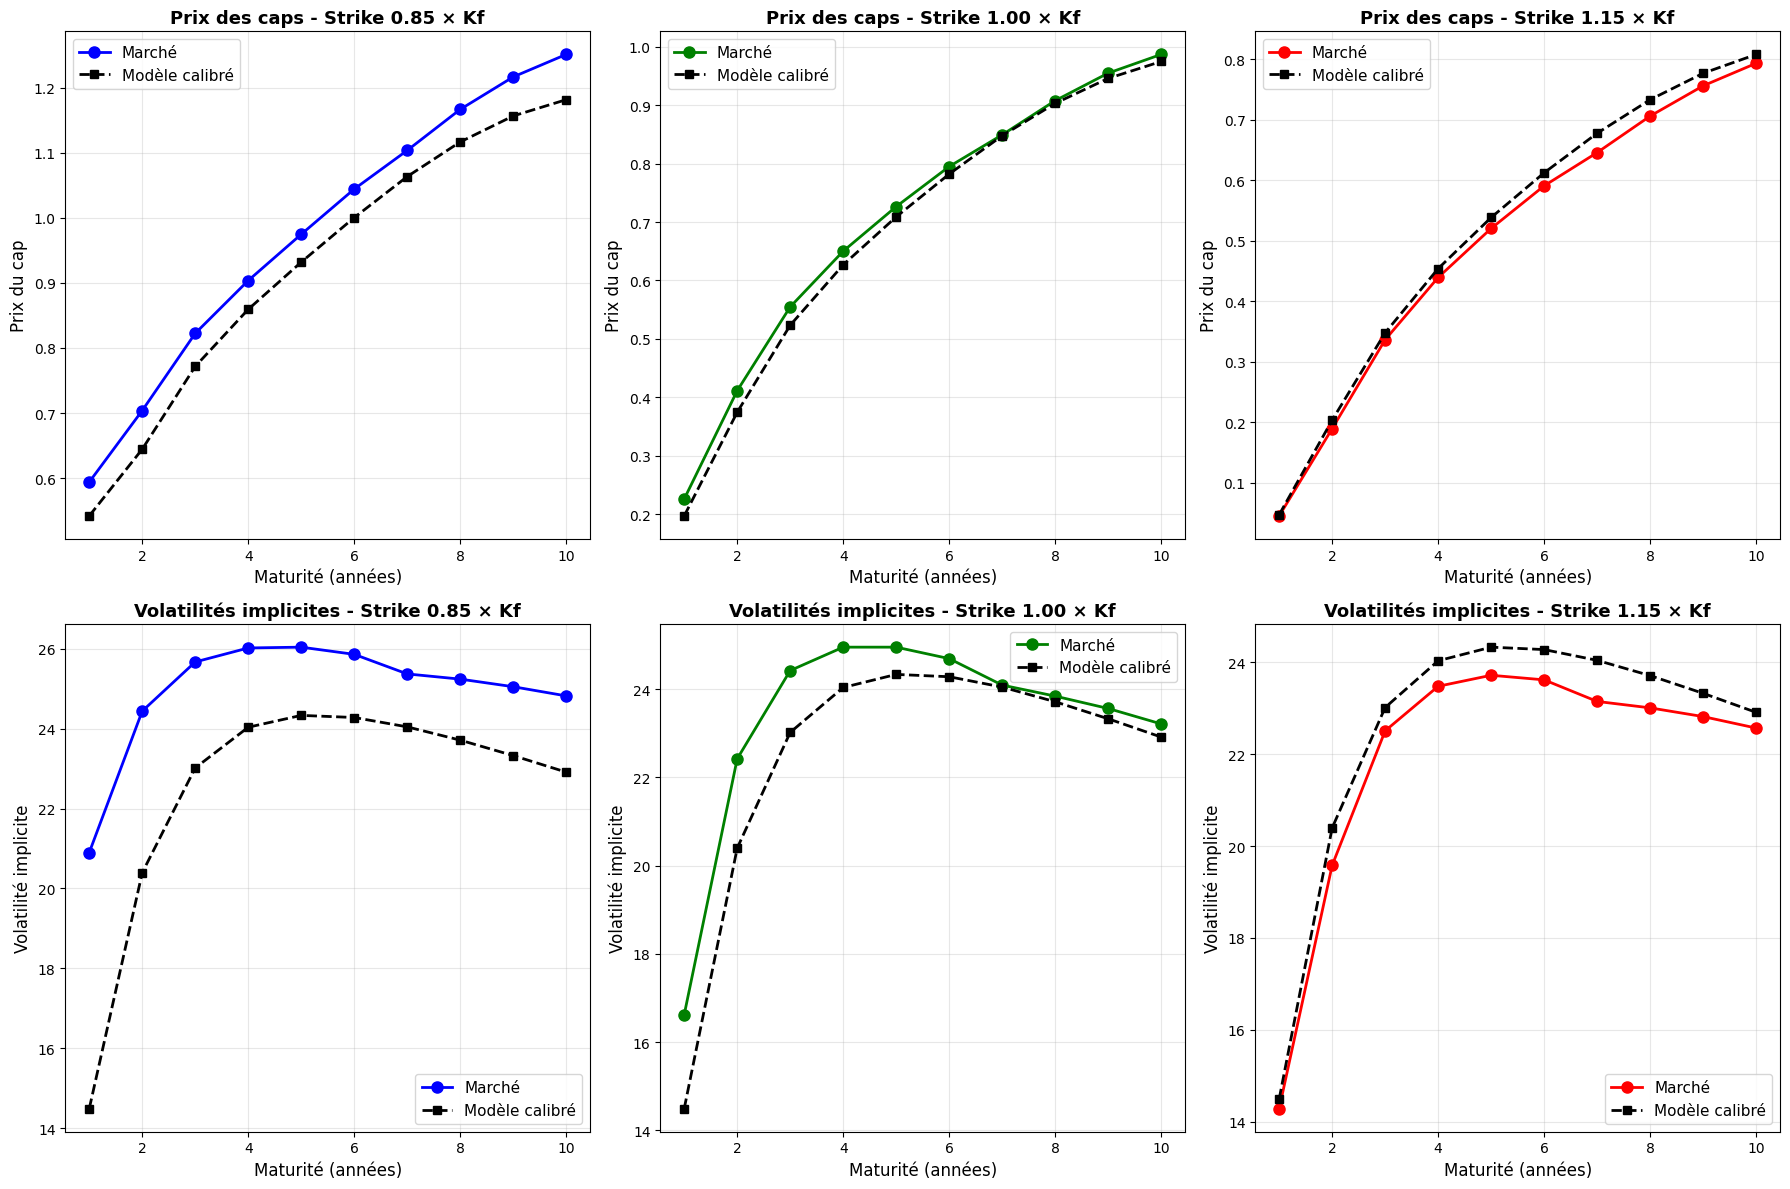


QUALITÉ DU CALIBRAGE - Graphiques générés


In [281]:
# Visualisation de la qualité du calibrage
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

strike_labels = ['0.85 × Kf', '1.00 × Kf', '1.15 × Kf']
strike_colors = ['blue', 'green', 'red']

# PREMIÈRE LIGNE: Prix des caps
for j in range(3):
    ax = axes[0, j]
    
    # Prix de marché
    ax.plot(cap_maturites_q3, market_cap_prices[j, :], 
            'o-', color=strike_colors[j], linewidth=2, 
            markersize=8, label='Marché')
    
    # Prix du modèle
    ax.plot(cap_maturites_q3, model_cap_prices[j, :], 
            's--', color='black', linewidth=2, 
            markersize=6, label='Modèle calibré')
    
    ax.set_xlabel('Maturité (années)', fontsize=12)
    ax.set_ylabel('Prix du cap', fontsize=12)
    ax.set_title(f'Prix des caps - Strike {strike_labels[j]}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

# DEUXIÈME LIGNE: Volatilités implicites
vol_market_arrays = [vol_085Kf, vol_Kf, vol_115Kf]

for j in range(3):
    ax = axes[1, j]
    
    # Volatilité de marché
    ax.plot(cap_maturites_q3, vol_market_arrays[j], 
            'o-', color=strike_colors[j], linewidth=2, 
            markersize=8, label='Marché')
    
    # Volatilité du modèle
    ax.plot(cap_maturites_q3, model_cap_vols[j, :], 
            's--', color='black', linewidth=2, 
            markersize=6, label='Modèle calibré')
    
    ax.set_xlabel('Maturité (années)', fontsize=12)
    ax.set_ylabel('Volatilité implicite', fontsize=12)
    ax.set_title(f'Volatilités implicites - Strike {strike_labels[j]}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q3_calibration_quality.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("QUALITÉ DU CALIBRAGE - Graphiques générés")
print("=" * 80)

In [282]:
# Tableaux détaillés de comparaison
print("\n" + "=" * 100)
print("COMPARAISON DES PRIX DE MARCHÉ ET DU MODÈLE")
print("=" * 100)

for j, strike_label in enumerate(['0.85 × Kf', '1.00 × Kf (ATM)', '1.15 × Kf']):
    print(f"\n{strike_label}")
    print("-" * 100)
    print(f"{'Maturité':<12} {'Prix Marché':<15} {'Prix Modèle':<15} {'Erreur Abs.':<15} {'Erreur Rel. %':<15}")
    print("-" * 100)
    
    for i, T in enumerate(cap_maturites_q3):
        price_mkt = market_cap_prices[j, i]
        price_mdl = model_cap_prices[j, i]
        err_abs = price_mdl - price_mkt
        err_rel = (err_abs / price_mkt) * 100 if price_mkt != 0 else 0
        
        print(f"{T:<12.1f} {price_mkt:<15.6f} {price_mdl:<15.6f} {err_abs:<15.6f} {err_rel:<15.4f}")

print("\n" + "=" * 100)
print("COMPARAISON DES VOLATILITÉS IMPLICITES")
print("=" * 100)

for j, strike_label in enumerate(['0.85 × Kf', '1.00 × Kf (ATM)', '1.15 × Kf']):
    print(f"\n{strike_label}")
    print("-" * 100)
    print(f"{'Maturité':<12} {'Vol. Marché':<15} {'Vol. Modèle':<15} {'Erreur Abs.':<15} {'Erreur Rel. %':<15}")
    print("-" * 100)
    
    for i, T in enumerate(cap_maturites_q3):
        vol_mkt = vol_market_arrays[j][i]
        vol_mdl = model_cap_vols[j, i]
        err_abs = vol_mdl - vol_mkt
        err_rel = (err_abs / vol_mkt) * 100 if vol_mkt != 0 else 0
        
        print(f"{T:<12.1f} {vol_mkt:<15.4f} {vol_mdl:<15.4f} {err_abs:<15.4f} {err_rel:<15.4f}")

# Statistiques globales
print("\n" + "=" * 100)
print("STATISTIQUES D'ERREUR GLOBALES")
print("=" * 100)

# Erreurs sur les prix
price_errors = (model_cap_prices - market_cap_prices).flatten()
price_rel_errors = ((model_cap_prices - market_cap_prices) / market_cap_prices * 100).flatten()

print(f"\nPRIX DES CAPS:")
print(f"  • Erreur absolue moyenne:        {np.mean(np.abs(price_errors)):>10.6f}")
print(f"  • Erreur absolue maximale:       {np.max(np.abs(price_errors)):>10.6f}")
print(f"  • RMSE:                          {np.sqrt(np.mean(price_errors**2)):>10.6f}")
print(f"  • Erreur relative moyenne:       {np.mean(np.abs(price_rel_errors)):>10.4f} %")
print(f"  • Erreur relative maximale:      {np.max(np.abs(price_rel_errors)):>10.4f} %")

# Erreurs sur les volatilités
vol_model_flat = model_cap_vols.flatten()
vol_market_flat = np.concatenate([vol_085Kf, vol_Kf, vol_115Kf])
vol_errors = vol_model_flat - vol_market_flat
vol_rel_errors = (vol_errors / vol_market_flat * 100)

print(f"\nVOLATILITÉS IMPLICITES:")
print(f"  • Erreur absolue moyenne:        {np.mean(np.abs(vol_errors)):>10.4f}")
print(f"  • Erreur absolue maximale:       {np.max(np.abs(vol_errors)):>10.4f}")
print(f"  • RMSE:                          {np.sqrt(np.mean(vol_errors**2)):>10.4f}")
print(f"  • Erreur relative moyenne:       {np.mean(np.abs(vol_rel_errors)):>10.4f} %")
print(f"  • Erreur relative maximale:      {np.max(np.abs(vol_rel_errors)):>10.4f} %")

print("\n" + "=" * 100)


COMPARAISON DES PRIX DE MARCHÉ ET DU MODÈLE

0.85 × Kf
----------------------------------------------------------------------------------------------------
Maturité     Prix Marché     Prix Modèle     Erreur Abs.     Erreur Rel. %  
----------------------------------------------------------------------------------------------------
1.0          0.593868        0.541835        -0.052033       -8.7616        
2.0          0.703854        0.644423        -0.059431       -8.4436        
3.0          0.822495        0.771685        -0.050810       -6.1776        
4.0          0.903688        0.859409        -0.044278       -4.8998        
5.0          0.974800        0.931991        -0.042808       -4.3915        
6.0          1.044318        1.000439        -0.043879       -4.2017        
7.0          1.103769        1.063520        -0.040249       -3.6465        
8.0          1.166839        1.116781        -0.050058       -4.2900        
9.0          1.216745        1.156715        -0.0